<a href="https://colab.research.google.com/github/KylerJacobs/Business-Data-Analytics-Intelligence/blob/main/Google_Causal_Impact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries ad Dates

In [ ]:
#Install Libraries
!pip install yfinance
!pip install tfcausalimpact

In [ ]:
#Import Libraries
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Dates
#training start = shoot for 10x the gap between treatment start and end. in this case, 1.5 months is about perfect.
training_start = "2020-09-01"
#end is one day before treatment_start
training_end = "2020-10-19"
#treatment start day before event
treatment_start = "2020-10-20"
#treatment end a few days after treatment start. can use only a few days because stocks are very volitile
treatment_end = "2020-10-23"
#end stock one day after treatment end
end_stock = "2020-10-24"

#Loading Financial Data

In [ ]:
#Bitcoin
#need to find bitcoin stock ticker. use finance.yahoo
y = ["BTC-USD"]
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = "1d")
y = y["Adj Close"].rename("y")
y[:1]

[*********************100%***********************]  1 of 1 completed


Date
2020-09-01    11970.478516
Name: y, dtype: float64

In [ ]:
#Load more stock data to reinforce Confounding Policy Change
#However, we should no pick any other cryptocurrencies.
#Etherium may be effected by paypals acceptance of Bitcoin, that woul dadd too many variables to our problem
stocks = ["ZAL.DE", "SQ", "CRSP", "TRMB", "JD", "DE", "KTOS", "GOOG"]
X = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1d")

[*********************100%***********************]  8 of 8 completed


#Data Preparation

In [ ]:
#Getting the adjusted close
X = X.iloc[:, :len(stocks)]
X.head(1)

Adj Close                                                         \
                 CRSP          DE     GOOG         JD       KTOS          SQ   
Date                                                                           
2020-09-01  93.419998  210.029663  83.0355  79.267685  19.700001  166.660004   

                          
             TRMB ZAL.DE  
Date                      
2020-09-01  53.41   77.0

In [ ]:
#Removing Level (Adj Close at top of table. not helpful for our analysis)
X.columns = X.columns.droplevel()
X.head(1)

,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,
2020-09-01,93.419998,210.029663,83.0355,79.267685,19.700001,166.660004,53.41,77.0


In [ ]:
#Time Zones. We need to be sure we arent deaing with timezones.
X.index = X.index.tz_localize(None)
X.index
#the "freqency" freq = 'B' is telling us the frequency is in business days.
#since we are working with stock prices, we only need to use business days

DatetimeIndex(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02',
               '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23'],
              dtype='datetime64[ns]', name='Date', freq='B')

In [ ]:
#Combine everything
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-01,11970.478516,93.419998,210.029663,83.035500,79.267685,19.700001,166.660004,53.410000,77.000000
2020-09-02,11414.034180,93.930000,209.470078,86.414001,79.959557,19.910000,162.880005,54.310001,77.000000
2020-09-03,10245.296875,85.690002,203.391754,82.092003,75.952454,19.520000,152.860001,50.900002,75.080002
2020-09-04,10511.813477,82.019997,203.903091,79.552002,76.874954,19.260000,146.389999,49.959999,71.739998
2020-09-08,10131.516602,81.459999,202.841812,76.619499,73.242615,19.230000,139.110001,49.139999,73.440002


#Data Analysis

In [ ]:
#Prepare a dataframe with only training data
#We are only using the training data because we want to analyse the control period. the period before the treatment
df_training = df[df.index <= training_end]
df_training.tail(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-10-19,11742.037109,107.720001,230.578705,76.730499,77.461121,20.639999,186.960007,51.970001,85.0


In [ ]:
#We need to now find comparable control groups
#Need to deal with stationarity on our own
#Stationarity:
from statsmodels.tsa.stattools import adfuller
test = adfuller(x = df_training.y)[1]
#The P-Value result is greater than 0.05 so the time series we have is not stationary.

#How to read - if else
if test < 0.05:
  print("the time series is stationary")
else:
  print("the time series is not stationary")

the time series is not stationary


In [ ]:
#Now we need to make Time Series stationary
#Differencing: subtract or divide
differencing = df_training.pct_change().dropna()
#Used percent change function here to better visualize stock c=rise or fall
differencing.head(2)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-02,-0.046485,0.005459,-0.002664,0.040687,0.008728,0.010660,-0.022681,0.016851,0.000000
2020-09-03,-0.102395,-0.087725,-0.029018,-0.050015,-0.050114,-0.019588,-0.061518,-0.062788,-0.024935


In [ ]:
#To show that our differencing worked:

from statsmodels.tsa.stattools import adfuller
test = adfuller(x = differencing.y)[1]
#Change out df_training for differencing varaibe we made to hold our differenced time series above

print(test)

if test < 0.05:
  print("the time series is stationary")
else:
  print("the time series is not stationary")

3.8054323617260893e-07
the time series is stationary


<Axes: >

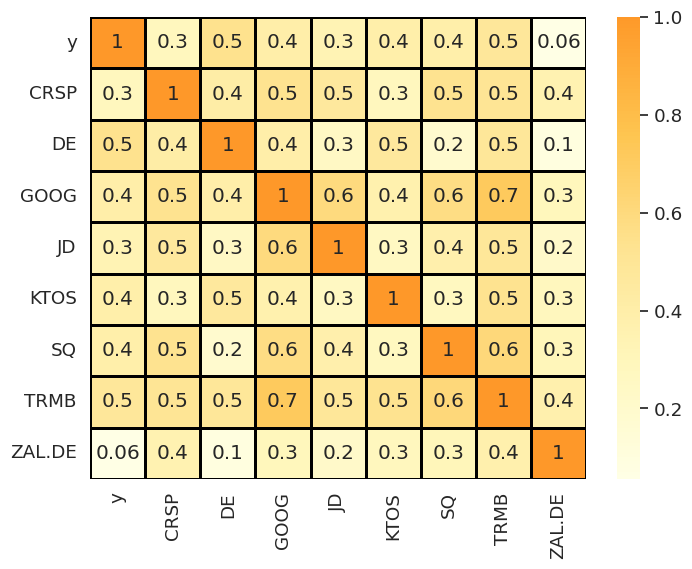

In [ ]:
#Correlation Matrix
#Visualize where our similar control group variables are
#Need similar statistical properties, not correlation due to a trend
plt.figure(figsize = (8, 6))
sns.set(font_scale = 1.2)
sns.heatmap(differencing.corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'YlOrBr',
            center = True,
            linewidth = 1,
            linecolor = "black")
#We want to focus on the y in the heatmap as the y variable we have holding bitcoin
#In the y column, we can see that it is not at all correlated to ZAL.DE and barely related to CRSP

#Causal Impact

In [ ]:
#Start by removing ZAL.DE since it had no correlation
df_final = df.drop(columns = ["ZAL.DE"])
df_final.head(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB
Date,,,,,,,,
2020-09-01,11970.478516,93.419998,210.029663,83.0355,79.267685,19.700001,166.660004,53.41


In [ ]:
#Pre and Post Period
#pre_period is period between training start and training end
pre_period = [training_start, training_end]
#post_period is period between treatment start and treatment end
post_period = [treatment_start, treatment_end]

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


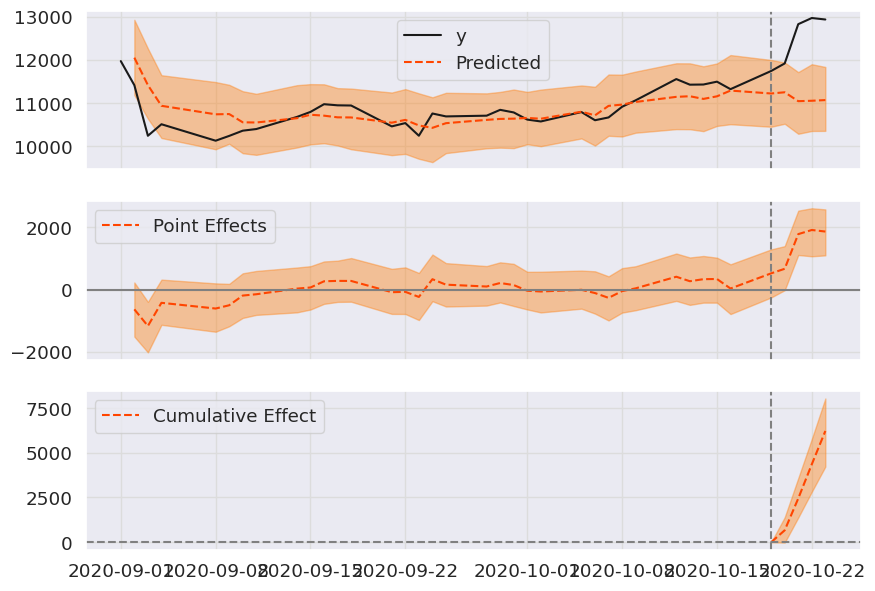

In [ ]:
#Google Causal Impact
impact = CausalImpact(data = df_final,
                      pre_period = pre_period,
                      post_period = post_period)
impact.plot()
#Interpretation:
  #Dotted line is Oct. 20th, day of treatment
  #orange dotted line is a "what if" scinereo taking all the other stock prices into account
  #Middle graph is showing the difference (delta) between the black line and orange line form the first graph
    #Middle graph is where we can really see the impact after treatment
    #Since we are using stock prices, the best graph for us is the middle graph
  #We can see, based on the middle graph, the "boom" paypal created and the leveling out shorly after, as predicted

#IN SUMMARY: the impact of paypal accepting bitcoin as an approved transaction, created a short term positive impact.
  #The initial impact did not accumulate meaning the boom happend quickly and then stabilized
  #A gradual increase, followed by stabilization
#The main advantage to using Google Causal Impact is being able to see the impact over time

#If we were not working with stock but rather sales or orders or store visits
#We would observe the third graph because that data is accumulative. you accumulate sales


In [ ]:
#Summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12659.36           50637.45
Prediction (s.d.)         11104.75 (243.42)  44419.0 (973.67)
95% CI                    [10660.5, 11614.69][42642.02, 46458.75]

Absolute effect (s.d.)    1554.61 (243.42)   6218.45 (973.67)
95% CI                    [1044.68, 1998.86] [4178.71, 7995.43]

Relative effect (s.d.)    14.0% (2.19%)      14.0% (2.19%)
95% CI                    [9.41%, 18.0%]     [9.41%, 18.0%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 12659.36. By contrast, in the absence of an
intervention, we would have expected an average response of 11104.75.
The 95% interval of this counterfactual prediction is [10660.5, 11614.69].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1554.61 with a 95% interval of
[1044.68, 1998.86]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 50637.45.
By contrast, had the intervention not taken place, we would have expected
a sum of 44419.0. The 95% interval of this prediction is [42642.02, 46458.75].


The above results are given in terms of absolute numbers. In relative
te